# II. Mean-Variance Optimization

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

### Notation
(Hidden LaTeX commands)







$$\newcommand{\mux}{\tilde{\boldsymbol{\mu}}}$$
$$\newcommand{\wtan}{\boldsymbol{\text{w}}^{\text{tan}}}$$
$$\newcommand{\wtarg}{\boldsymbol{\text{w}}^{\text{port}}}$$
$$\newcommand{\mutarg}{\tilde{\boldsymbol{\mu}}^{\text{port}}}$$
$$\newcommand{\wEW}{\boldsymbol{\text{w}}^{\text{EW}}}$$
$$\newcommand{\wRP}{\boldsymbol{\text{w}}^{\text{RP}}}$$
$$\newcommand{\wREG}{\boldsymbol{\text{w}}^{\text{REG}}}$$

## Loading Data

In [46]:
file_path = './../data/multi_asset_etf_data.xlsx'

# Load the different sheets from the Excel file
multi_asset_etf_descriptions = pd.read_excel(file_path) # first sheet

multi_asset_etf_prices = pd.read_excel(file_path, sheet_name='prices')

multi_asset_etf_tot_ret = pd.read_excel(file_path, sheet_name='total returns')
risk_free_rate = multi_asset_etf_tot_ret.loc[:, ['SHV']]
multi_asset_etf_tot_ret = multi_asset_etf_tot_ret.drop('SHV', axis=1)

multi_asset_etf_excess_ret = pd.read_excel(file_path, sheet_name='excess returns')

excess_returns = multi_asset_etf_excess_ret[multi_asset_etf_excess_ret.columns[1:]] # drop the date column
excess_returns

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
0,0.0084,-0.0016,0.1550,0.1146,0.1379,-0.0280,0.2956,0.2296,0.0223,0.0988,-0.0185
1,0.0541,0.1631,0.1599,0.1324,0.0290,-0.0203,0.0232,0.0544,0.0283,0.0589,0.0204
2,0.0045,-0.0269,-0.0231,-0.0146,0.0329,-0.0062,-0.0255,0.0414,-0.0040,-0.0013,0.0014
3,0.0313,0.0186,0.1102,0.1004,0.0692,0.0083,0.1058,0.1433,0.0154,0.0746,0.0009
4,0.0072,-0.0408,-0.0136,0.0446,-0.0174,0.0072,0.1315,0.0330,-0.0046,0.0365,0.0080
...,...,...,...,...,...,...,...,...,...,...,...
168,-0.0056,-0.0107,-0.0115,0.0263,-0.0011,0.0051,0.0061,0.0315,0.0020,0.0129,-0.0026
169,-0.0292,-0.0673,-0.0273,-0.0433,-0.0156,-0.0176,-0.0435,-0.0224,-0.0097,0.0014,-0.0152
170,0.0034,0.0247,0.0392,0.0400,0.0131,-0.0173,0.0526,0.0420,0.0179,0.0601,-0.0081
171,0.0060,0.0834,0.0566,0.0232,0.0073,-0.0104,0.0136,0.0608,0.0156,0.0289,-0.0034


## 1. Summary Statistics
* Calculate and display the mean and volatility of each asset’s excess return. (Recall we use volatility to refer to standard deviation.)
* Which assets have the best and worst Sharpe ratios? Recall that the Sharpe Ratio is simply the ratio of the mean-to-volatility of excess returns:
$$\text{sharpe ratio of investment }i = \frac{\mu_{x_i}}{\sigma_i}$$

In [47]:
def summary_statistics_annualized(returns, annual_factor = 12):
    """This functions returns the summary statistics for the input total/excess returns passed
    into the function"""

    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = summary_statistics['Mean'] / summary_statistics['Vol']
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Kurtosis'] = returns.kurtosis()
    summary_statistics['VaR 5%'] = returns.quantile(0.05, axis=0)
    summary_statistics['CVaR 5%'] = returns[returns <= returns.quantile(0.05, axis=0)].mean()

    return summary_statistics

summary_stats_excess_returns = summary_statistics_annualized(excess_returns)
summary_stats_excess_returns

,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
BWX,-0.0018,0.0834,-0.0221,-0.0694,0.0780,-0.3006,0.9020,-0.0434,-0.0564
DBC,0.0254,0.1790,0.1422,-0.1776,0.1631,-0.3254,0.6971,-0.0859,-0.1150
EEM,0.0649,0.1965,0.3302,-0.1791,0.1628,0.1369,0.8588,-0.0817,-0.1128
EFA,0.0816,0.1660,0.4916,-0.1452,0.1429,-0.0658,0.7240,-0.0765,-0.1008
HYG,0.0642,0.0892,0.7197,-0.1044,0.1379,0.4607,5.7623,-0.0287,-0.0512
IEF,0.0143,0.0624,0.2287,-0.0476,0.0461,-0.0875,0.1744,-0.0292,-0.0396
IYR,0.1295,0.1871,0.6920,-0.2005,0.2956,0.4899,4.7454,-0.0650,-0.0972
PSP,0.0799,0.2274,0.3516,-0.2951,0.2296,-0.4402,2.6579,-0.1030,-0.1465
QAI,0.0190,0.0508,0.3734,-0.0605,0.0364,-0.5567,1.7665,-0.0196,-0.0342
SPY,0.1437,0.1477,0.9732,-0.1290,0.1268,-0.3868,0.6016,-0.0675,-0.0869


In [48]:
print("The asset with the best Sharpe ratio is: ")
display(summary_stats_excess_returns[summary_stats_excess_returns['Sharpe'] == summary_stats_excess_returns['Sharpe'].max()])
print("The asset with the worst Sharpe ratio is: ")
display(summary_stats_excess_returns[summary_stats_excess_returns['Sharpe'] == summary_stats_excess_returns['Sharpe'].min()])

The asset with the best Sharpe ratio is: 


,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
SPY,0.1437,0.1477,0.9732,-0.1290,0.1268,-0.3868,0.6016,-0.0675,-0.0869


The asset with the worst Sharpe ratio is: 


,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
BWX,-0.0018,0.0834,-0.0221,-0.0694,0.0780,-0.3006,0.9020,-0.0434,-0.0564


## 2. Descriptive Analysis
* Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
* How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
BWX,1.0000,0.3498,0.6476,0.6217,0.5577,0.4345,0.4535,0.5249,0.6680,0.4657,0.6171
DBC,0.3498,1.0000,0.5657,0.5819,0.4732,-0.3217,0.3183,0.4961,0.5479,0.5099,0.1367
EEM,0.6476,0.5657,1.0000,0.8516,0.7260,-0.1023,0.6218,0.7717,0.8072,0.7346,0.3027
EFA,0.6217,0.5819,0.8516,1.0000,0.7715,-0.1323,0.6979,0.8919,0.8537,0.8716,0.2875
HYG,0.5577,0.4732,0.7260,0.7715,1.0000,-0.0086,0.7576,0.8238,0.7688,0.7704,0.3659
IEF,0.4345,-0.3217,-0.1023,-0.1323,-0.0086,1.0000,0.0736,-0.1187,0.0557,-0.1557,0.7061
IYR,0.4535,0.3183,0.6218,0.6979,0.7576,0.0736,1.0000,0.7602,0.6560,0.7536,0.3972
PSP,0.5249,0.4961,0.7717,0.8919,0.8238,-0.1187,0.7602,1.0000,0.8383,0.8957,0.3209
QAI,0.6680,0.5479,0.8072,0.8537,0.7688,0.0557,0.6560,0.8383,1.0000,0.8410,0.4597
SPY,0.4657,0.5099,0.7346,0.8716,0.7704,-0.1557,0.7536,0.8957,0.8410,1.0000,0.2946


MIN Correlation pair is ('DBC', 'IEF')
MAX Correlation pair is ('SPY', 'PSP')


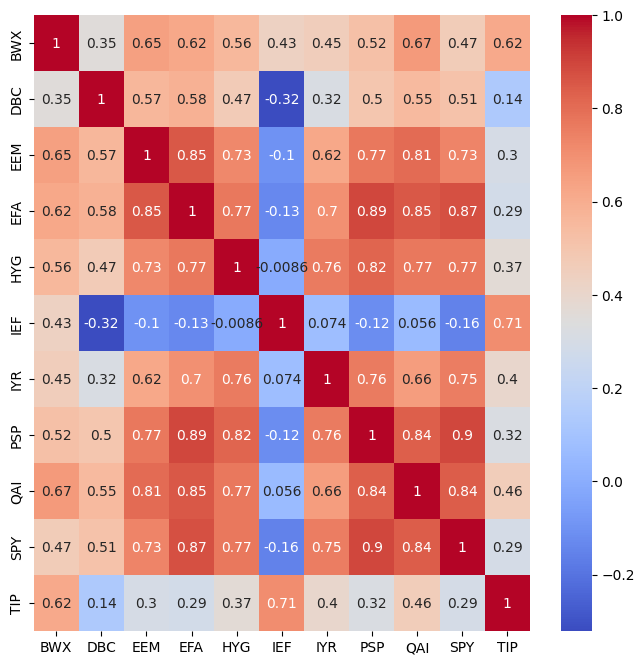

In [52]:
correlation_matrix = excess_returns.corr()
display(correlation_matrix)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# This unstacks the correlation dataframe 11x11 into 121x1, 
# while keeping col and row names as multi-index and sorts the values
# Then converted to a dataframe with the column name 'Correlations'
corr_rank = correlation_matrix.unstack().sort_values().to_frame('Correlations')
corr_rank = corr_rank[corr_rank['Correlations'] != 1]
pair_min = corr_rank.index[0]
pair_max = corr_rank.index[-1]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

TIPS

In [54]:
display(correlation_matrix[correlation_matrix.index == 'TIP'])

summary_stats_excess_returns[summary_stats_excess_returns.index.isin(['IEF', 'BWX', 'TIP'])]

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
TIP,0.6171,0.1367,0.3027,0.2875,0.3659,0.7061,0.3972,0.3209,0.4597,0.2946,1.0000


,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
BWX,-0.0018,0.0834,-0.0221,-0.0694,0.0780,-0.3006,0.9020,-0.0434,-0.0564
IEF,0.0143,0.0624,0.2287,-0.0476,0.0461,-0.0875,0.1744,-0.0292,-0.0396
TIP,0.0223,0.0515,0.4332,-0.0676,0.0422,-0.6380,2.5229,-0.0204,-0.0329


TIPS substantially outperformed both domestic (IEF) and international bonds (BMX) in terms of high mean, low vol and high Sharpe.
* TIPS have an above-average Sharpe ratio, (relative to these 11 assets.)
* TIPS have a low mean, but a very low volatility. 

Regarding correlation,
* TIPS have low correlations to most the other assets.
* TIPS have substantial correlation to IEF and BWX. But these correlations are ~60% and 70%--well below the correlation between SPY and most the equity-based investments. 

## 3. The MV frontier.
* Compute and display the weights of the tangency portfolios: $w_{tan}$.
* Does the ranking of weights align with the ranking of Sharpe ratios?
* Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to
$w_{tan}$.


In [89]:
def tangency_weights(returns, shrinkage = 1):
    """This functions returns the tangency weights for the input total/excess returns.
    It calculates the mean, covariance matrix, and the inverse of the covariance matrix,
    and then calculates the tangency weights using the formula in slide L1p50.
    Features: covariance shrinkage to improve numerical stability when inverting cov."""
    
    cov = returns.cov()
    cov_diag = np.diag(np.diag(cov)) # calling twice to get 2D instead of 1D array
    cov_mat = shrinkage * cov + (1 - shrinkage) * cov_diag
    cov_inverse = np.linalg.inv(cov_mat * 12)

    ones = np.ones(returns.shape[1]) # number of columns, after dropping the date column
    means = returns.mean() * 12

    tangency_wghts = cov_inverse @ means / (ones @ cov_inverse @ means)
    tangency_wghts = pd.DataFrame(tangency_wghts, index=returns.columns, columns=['Tangency Weights'])
    
    return tangency_wghts

tangency_weights(excess_returns)

,Tangency Weights
BWX,-1.4650
DBC,0.0284
EEM,0.2610
EFA,0.4529
HYG,1.5289
IEF,1.8940
IYR,-0.2428
PSP,-1.2711
QAI,-3.1334
SPY,2.5900


We see that the tangency weights ranking is quite different from the Sharpe rankings. (Correlation between the two series is only about 50%.)

In [103]:
w_t = tangency_weights(excess_returns)
mv_frontier = w_t.merge(summary_stats_excess_returns['Sharpe'], on=w_t.index).rename(columns={'key_0':'assets'}).set_index('assets')
mv_frontier

,Tangency Weights,Sharpe
assets,,
BWX,-1.4650,-0.0221
DBC,0.0284,0.1422
EEM,0.2610,0.3302
EFA,0.4529,0.4916
HYG,1.5289,0.7197
IEF,1.8940,0.2287
IYR,-0.2428,0.6920
PSP,-1.2711,0.3516
QAI,-3.1334,0.3734


In [104]:
mv_frontier.corr()

,Tangency Weights,Sharpe
Tangency Weights,1.0000,0.5080
Sharpe,0.5080,1.0000


In [131]:
display(excess_returns @ w_t)
w_tan_summary_statistics = summary_statistics_annualized(excess_returns @ w_t)
w_tan_summary_statistics

,Tangency Weights
0,0.0534
1,0.0293
2,-0.0181
3,0.0883
4,0.0299
...,...
168,0.0092
169,0.0245
170,0.0416
171,-0.0454


,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
Tangency Weights,0.3702,0.1915,1.9328,-0.1087,0.2041,0.3000,0.6912,-0.0474,-0.0784




## 4. TIPS
Assess how much the tangency portfolio (and performance) change if...
* TIPS are dropped completely from the investment set.
* The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.

Based on the analysis, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?

In [110]:
summary_stats_excess_returns

,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
BWX,-0.0018,0.0834,-0.0221,-0.0694,0.0780,-0.3006,0.9020,-0.0434,-0.0564
DBC,0.0254,0.1790,0.1422,-0.1776,0.1631,-0.3254,0.6971,-0.0859,-0.1150
EEM,0.0649,0.1965,0.3302,-0.1791,0.1628,0.1369,0.8588,-0.0817,-0.1128
EFA,0.0816,0.1660,0.4916,-0.1452,0.1429,-0.0658,0.7240,-0.0765,-0.1008
HYG,0.0642,0.0892,0.7197,-0.1044,0.1379,0.4607,5.7623,-0.0287,-0.0512
IEF,0.0143,0.0624,0.2287,-0.0476,0.0461,-0.0875,0.1744,-0.0292,-0.0396
IYR,0.1295,0.1871,0.6920,-0.2005,0.2956,0.4899,4.7454,-0.0650,-0.0972
PSP,0.0799,0.2274,0.3516,-0.2951,0.2296,-0.4402,2.6579,-0.1030,-0.1465
QAI,0.0190,0.0508,0.3734,-0.0605,0.0364,-0.5567,1.7665,-0.0196,-0.0342
SPY,0.1437,0.1477,0.9732,-0.1290,0.1268,-0.3868,0.6016,-0.0675,-0.0869


In [166]:
# TIPS completely dropped from the investment set
excess_returns_no_tips = excess_returns.drop('TIP', axis=1)
summary_stats_excess_returns_no_tips = summary_statistics_annualized(excess_returns_no_tips)

w_t_no_tips = tangency_weights(excess_returns_no_tips)
mv_frontier_no_tips = w_t_no_tips.merge(summary_stats_excess_returns_no_tips['Sharpe'], on=w_t_no_tips.index).rename(columns={'key_0':'assets'}).set_index('assets')
display(mv_frontier_no_tips)
display(mv_frontier_no_tips.corr())

w_tan_no_tip_summary_statistics = summary_statistics_annualized(excess_returns_no_tips @ w_t_no_tips)
w_tan_no_tip_summary_statistics.index = w_tan_no_tip_summary_statistics.index + ' (TIP dropped)'
w_tan_no_tip_summary_statistics

,Tangency Weights,Sharpe
assets,,
BWX,-1.5127,-0.0221
DBC,0.0552,0.1422
EEM,0.2781,0.3302
EFA,0.4415,0.4916
HYG,1.5931,0.7197
IEF,2.2125,0.2287
IYR,-0.2459,0.6920
PSP,-1.3141,0.3516
QAI,-3.2390,0.3734


,Tangency Weights,Sharpe
Tangency Weights,1.0000,0.4915
Sharpe,0.4915,1.0000


,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
Tangency Weights (TIP dropped),0.3863,0.2001,1.9304,-0.1151,0.2117,0.2608,0.6252,-0.0515,-0.0838


In [167]:
# TIPS adjusted
adj = 0.0012
excess_returns_hi_tips = excess_returns.copy()
excess_returns_hi_tips['TIP'] = excess_returns_hi_tips['TIP'] + adj
summary_stats_excess_returns_hi_tips = summary_statistics_annualized(excess_returns_hi_tips)

w_t_hi_tips = tangency_weights(excess_returns_hi_tips)
mv_frontier_hi_tips = w_t_hi_tips.merge(summary_stats_excess_returns_hi_tips['Sharpe'], on=w_t_hi_tips.index).rename(columns={'key_0':'assets'}).set_index('assets')
display(mv_frontier_hi_tips)
display(mv_frontier_hi_tips.corr())

w_tan_hi_tip_summary_statistics = summary_statistics_annualized(excess_returns_hi_tips @ w_t_hi_tips)
w_tan_hi_tip_summary_statistics.index = w_tan_hi_tip_summary_statistics.index + ' (TIP adjusted)'
w_tan_hi_tip_summary_statistics

,Tangency Weights,Sharpe
assets,,
BWX,-1.2629,-0.0221
DBC,-0.0846,0.1422
EEM,0.1889,0.3302
EFA,0.5012,0.4916
HYG,1.2574,0.7197
IEF,0.5468,0.2287
IYR,-0.2296,0.6920
PSP,-1.0890,0.3516
QAI,-2.6871,0.3734


,Tangency Weights,Sharpe
Tangency Weights,1.0000,0.6350
Sharpe,0.6350,1.0000


,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
Tangency Weights (TIP adjusted),0.3289,0.1619,2.0310,-0.0805,0.1772,0.4778,0.9864,-0.0442,-0.0618


In [168]:
pd.concat([w_tan_summary_statistics, w_tan_no_tip_summary_statistics, w_tan_hi_tip_summary_statistics])

,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
Tangency Weights,0.3702,0.1915,1.9328,-0.1087,0.2041,0.3000,0.6912,-0.0474,-0.0784
Tangency Weights (TIP dropped),0.3863,0.2001,1.9304,-0.1151,0.2117,0.2608,0.6252,-0.0515,-0.0838
Tangency Weights (TIP adjusted),0.3289,0.1619,2.0310,-0.0805,0.1772,0.4778,0.9864,-0.0442,-0.0618


### Conclusions on TIPS

* Dropping TIPS from the investment set barely impacts the weights or the resulting performance.
* Adjusting the mean of TIPS upward even just 1 standard error substantially impacts the allocations and moderately boosts the resulting performance.

Based on just a mean-variance analysis, it seems one could reasonably go either way with TIPS as an alternate asset class. In the argument to keep it separate, there is more diversification between TIPS and bonds than between SPY and many other equity buckets Harvard has. On the other hand, TIPS mostly impact the allocation to domestic bonds and might be seen as another asset in that bucket.

# III. Allocation

* Continue with the same data file as the previous section.

* Suppose the investor has a targeted mean excess return (per month) of $\mutarg = 0.01$.

Build the following portfolios:

#### Equally-weighted (EW)
Rescale the entire weighting vector to have target mean $\mutarg$. Thus, the $i$ element of the weight vector is,
$$\wEW_i = \frac{1}{n}$$

#### “Risk-parity” (RP)
Risk-parity is a term used in a variety of ways, but here we have in mind setting the weight of the portfolio to be proportional to the inverse of its full-sample variance estimate. Thus, the $i$ element of the weight vector is,
$$\wRP_i = \frac{1}{\sigma_i^2}$$

#### Regularized (REG)
Much like the Mean-Variance portfolio, set the weights proportional to 
$$\wREG \sim \widehat{\Sigma}^{-1}\mux$$
but this time, use a regularized covariance matrix,
$$\widehat{\Sigma} = \frac{\Sigma + \Sigma_D}{2}$$
where $\Sigma_D$ denotes a *diagonal* matrix of the security variances, with zeros in the off-diagonals.

Thus, $\widehat{\Sigma}$ is obtained from the usual covariance matrix, $\Sigma$, but shrinking all the covariances to half their estimated values. 


### Comparing

In order to compare all these allocation methods, (those above, along with the tangency portfolio obtained in the previous section,) rescale each weight vector, such that it has targeted mean return of $\mutarg$.

* Calculate the performance of each of these portfolios over the sample.
* Report their mean, volatility, and Sharpe ratio. 
* How do these compare across the four allocation methods?

In [ ]:
target_mean = 0.015
w_t_no_tips.loc['TIP'] = 0
weights = pd.DataFrame(index=excess_returns.columns, columns=['Tangency', 'Tangency no TIP', 'Tangency hi TIP', 'Equally Weighted', 'Risk Parity', 'Regularized'])

weights['Tangency'] = tangency_weights(excess_returns)
weights['Tangency no TIP'] = w_t_no_tips.values
weights['Tangency hi TIP'] = w_t_hi_tips.values
weights['Equally Weighted'] = 1 / len(excess_returns.columns)
weights['Risk Parity'] = 1 / excess_returns.var()
weights['Regularized'] = tangency_weights(excess_returns, shrinkage = 0.5)

weights *= target_mean / (excess_returns.mean() @ weights)

weights

,Tangency,Tangency no TIP,Tangency hi TIP,Equally Weighted,Risk Parity,Regularized
BWX,-0.7123,-0.7049,-0.7526,0.2800,0.5821,-0.6917
DBC,0.0138,0.0257,-0.0504,0.2800,0.1263,-0.0467
EEM,0.1269,0.1296,0.1126,0.2800,0.1047,-0.0184
EFA,0.2202,0.2057,0.2987,0.2800,0.1468,0.0938
HYG,0.7434,0.7424,0.7494,0.2800,0.5089,0.6028
IEF,0.9210,1.0309,0.3259,0.2800,1.0387,0.5417
IYR,-0.1180,-0.1146,-0.1368,0.2800,0.1156,0.2085
PSP,-0.6181,-0.6123,-0.6490,0.2800,0.0782,-0.1249
QAI,-1.5236,-1.5093,-1.6014,0.2800,1.5669,-0.2666
SPY,1.2594,1.2727,1.1872,0.2800,0.1855,0.7105


In [170]:
summary_statistics_annualized(excess_returns @ weights)

,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
Tangency,0.1800,0.0931,1.9328,-0.0528,0.0992,0.3000,0.6912,-0.0231,-0.0381
Tangency no TIP,0.1800,0.0932,1.9304,-0.0536,0.0986,0.2608,0.6252,-0.0240,-0.0390
Tangency hi TIP,0.1800,0.0965,1.8650,-0.0493,0.1043,0.4778,0.9864,-0.0277,-0.0382
Equally Weighted,0.1800,0.3199,0.5627,-0.3652,0.2840,-0.3881,1.8369,-0.1274,-0.2027
Risk Parity,0.1800,0.3265,0.5513,-0.3498,0.2354,-0.6240,1.4973,-0.1498,-0.2147
Regularized,0.1800,0.1411,1.2753,-0.1117,0.1566,-0.0136,1.6431,-0.0539,-0.0784


***

# IV. Out-of-Sample Performance

## 1. One-step Out-of-Sample (OOS) Performance
Let’s divide the sample to both compute a portfolio and then check its performance out of sample.
* Using only data through the end of 2021, compute the weights built in Section 3.
* Rescale the weights, (using just the in-sample data,) to set each allocation to have the same mean return of $\mutarg$.
* Using those weights, calculate the portfolio’s Sharpe ratio within that sample.
* Again using those weights, (derived using data through 2021,) calculate the portfolio’s OOS Sharpe ratio, which is based only on performance in 2022-2023.

In [191]:
excess_returns_IS = multi_asset_etf_excess_ret.set_index('Date')[:'2020'].reset_index() # in-sample
excess_returns_OOS = multi_asset_etf_excess_ret.set_index('Date')['2021':].reset_index() # out-of-sample

excess_returns_IS = excess_returns_IS.drop('Date', axis=1)
excess_returns_OOS = excess_returns_OOS.drop('Date', axis=1)

excess_returns_IS_adj = excess_returns_IS.copy()
excess_returns_IS_adj['TIP'] += adj

display(excess_returns_IS)
display(excess_returns_IS_adj)

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
0,0.0084,-0.0016,0.1550,0.1146,0.1379,-0.0280,0.2956,0.2296,0.0223,0.0988,-0.0185
1,0.0541,0.1631,0.1599,0.1324,0.0290,-0.0203,0.0232,0.0544,0.0283,0.0589,0.0204
2,0.0045,-0.0269,-0.0231,-0.0146,0.0329,-0.0062,-0.0255,0.0414,-0.0040,-0.0013,0.0014
3,0.0313,0.0186,0.1102,0.1004,0.0692,0.0083,0.1058,0.1433,0.0154,0.0746,0.0009
4,0.0072,-0.0408,-0.0136,0.0446,-0.0174,0.0072,0.1315,0.0330,-0.0046,0.0365,0.0080
...,...,...,...,...,...,...,...,...,...,...,...
136,0.0041,0.0464,0.0289,0.0473,-0.0002,-0.0097,0.0024,0.0599,0.0127,0.0698,0.0089
137,-0.0122,-0.0354,-0.0100,-0.0204,-0.0093,0.0033,-0.0234,-0.0385,-0.0083,-0.0374,-0.0037
138,0.0101,-0.0315,0.0139,-0.0356,0.0039,-0.0139,-0.0293,-0.0075,-0.0046,-0.0251,-0.0069
139,0.0207,0.1022,0.0901,0.1429,0.0337,0.0036,0.0860,0.1624,0.0336,0.1090,0.0123


,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
0,0.0084,-0.0016,0.1550,0.1146,0.1379,-0.0280,0.2956,0.2296,0.0223,0.0988,-0.0173
1,0.0541,0.1631,0.1599,0.1324,0.0290,-0.0203,0.0232,0.0544,0.0283,0.0589,0.0216
2,0.0045,-0.0269,-0.0231,-0.0146,0.0329,-0.0062,-0.0255,0.0414,-0.0040,-0.0013,0.0026
3,0.0313,0.0186,0.1102,0.1004,0.0692,0.0083,0.1058,0.1433,0.0154,0.0746,0.0021
4,0.0072,-0.0408,-0.0136,0.0446,-0.0174,0.0072,0.1315,0.0330,-0.0046,0.0365,0.0092
...,...,...,...,...,...,...,...,...,...,...,...
136,0.0041,0.0464,0.0289,0.0473,-0.0002,-0.0097,0.0024,0.0599,0.0127,0.0698,0.0101
137,-0.0122,-0.0354,-0.0100,-0.0204,-0.0093,0.0033,-0.0234,-0.0385,-0.0083,-0.0374,-0.0025
138,0.0101,-0.0315,0.0139,-0.0356,0.0039,-0.0139,-0.0293,-0.0075,-0.0046,-0.0251,-0.0057
139,0.0207,0.1022,0.0901,0.1429,0.0337,0.0036,0.0860,0.1624,0.0336,0.1090,0.0135


In [178]:
target_mean = 0.015
w_t_no_tips.loc['TIP'] = 0
weights = pd.DataFrame(index=excess_returns_train.columns, columns=['Tangency', 'Tangency no TIP', 'Tangency hi TIP', 'Equally Weighted', 'Risk Parity', 'Regularized'])

weights['Tangency'] = tangency_weights(excess_returns_train)
weights['Tangency no TIP'] = w_t_no_tips.values
weights['Tangency hi TIP'] = w_t_hi_tips.values
weights['Equally Weighted'] = 1 / len(excess_returns_train.columns)
weights['Risk Parity'] = 1 / excess_returns_train.var()
weights['Regularized'] = tangency_weights(excess_returns_train, shrinkage = 0.5)

weights *= target_mean / (excess_returns_train.mean() @ weights)

weights

,Tangency,Tangency no TIP,Tangency hi TIP,Equally Weighted,Risk Parity,Regularized
BWX,-0.2236,-0.6595,-0.7007,0.2146,0.4318,-0.2776
DBC,-0.0340,0.0240,-0.0469,0.2146,0.0733,-0.0825
EEM,0.0099,0.1212,0.1048,0.2146,0.0620,-0.0226
EFA,0.1099,0.1925,0.2781,0.2146,0.0909,0.0528
HYG,0.7315,0.6946,0.6977,0.2146,0.3234,0.4356
IEF,0.8890,0.9646,0.3034,0.2146,0.7346,0.7199
IYR,-0.1903,-0.1072,-0.1274,0.2146,0.0714,0.1358
PSP,-0.3926,-0.5729,-0.6042,0.2146,0.0499,-0.0425
QAI,-1.4963,-1.4121,-1.4910,0.2146,1.0321,-0.1176
SPY,1.1447,1.1908,1.1053,0.2146,0.1203,0.4955


In [179]:
# in-sample performance
summary_statistics_annualized(excess_returns_train @ weights)

,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
Tangency,0.1800,0.0730,2.4648,-0.0315,0.0808,0.3570,0.7013,-0.0201,-0.0257
Tangency no TIP,0.1800,0.0812,2.2172,-0.0413,0.0903,0.1403,0.4210,-0.0202,-0.0322
Tangency hi TIP,0.1800,0.0820,2.1944,-0.0459,0.0914,0.2829,0.7761,-0.0217,-0.0321
Equally Weighted,0.1800,0.2317,0.7768,-0.2799,0.2176,-0.3835,2.7019,-0.0831,-0.1396
Risk Parity,0.1800,0.1883,0.9558,-0.1962,0.1318,-0.4309,1.0644,-0.0862,-0.1134
Regularized,0.1800,0.1083,1.6615,-0.0880,0.1123,0.0065,0.8750,-0.0414,-0.0531


In [180]:
# out-of-sample performance
summary_statistics_annualized(excess_returns_test @ weights)

,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%
Tangency,-0.0181,0.1684,-0.1077,-0.0636,0.1097,0.9489,0.7130,-0.0564,-0.0636
Tangency no TIP,0.0798,0.1241,0.6429,-0.0502,0.0923,0.9461,1.0586,-0.0394,-0.0502
Tangency hi TIP,0.0726,0.1356,0.5355,-0.0451,0.0971,1.2596,1.2223,-0.0362,-0.0451
Equally Weighted,-0.1836,0.3232,-0.5681,-0.1946,0.1494,0.0248,-0.6431,-0.1499,-0.1946
Risk Parity,-0.3390,0.3758,-0.9021,-0.2438,0.1602,0.0590,-0.4716,-0.1633,-0.2438
Regularized,-0.1649,0.2286,-0.7216,-0.1345,0.1320,0.3081,-0.1063,-0.0945,-0.1345


## 2. Rolling OOS Performance

Iterate the Out-of-Sample performance every year, not just the final year. Namely,
* Start at the end of 2014, and calculate the weights through that time. Rescale them using the mean returns through that time.
* Apply the weights to the returns in the upcoming year, (2015.)
* Step forward a year in time, and recompute.
* Continue until again calculating the weights through 2022 and applying them to the returns in 2023.

Report the mean, volatility, and Sharpe from this dynamic approach for the following portfolios:
* mean-variance (tangency)
* equally-weighted
* risk-parity
* regularized

***

# V. Without a Riskless Asset

Re-do Section 2 above, but in the model without a risk-free rate.

That is, build the MV allocation using the two-part formula in the `Mean-Variance` section of the notes.
* This essentially substitutes the risk-free rate with the minimum-variance portfolio.
* Now, the allocation depends nonlinearly on the target mean return, $\mutarg$. (With a risk-free rate, we simply scale the weights up and down to achieve the mean return.)

You will find that, conceptually, the answers are very similar. 